# 2D prediction for the entire Kevitsa deposit

In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)

In [8]:
y

tensor([[0.2382],
        [0.4107],
        [0.5361],
        ...,
        [0.5078],
        [0.5893],
        [0.6332]])

C:\Users\23478671\AppData\Local\Temp\ipykernel_2948\1855914482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_data[column] = deposit_data[column] - min_values[column]
C:\Users\23478671\AppData\Local\Temp\ipykernel_2948\1855914482.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)
C:\Users\23478671\AppData\Local\Temp\ipykernel_2948\1855914482.py:28: SettingWithCopyWarning: 
A value is trying to be set on a 

- Iteration 0, MSE: 0.296
- Iteration 10, MSE: 0.047
- Iteration 20, MSE: 0.016
- Iteration 30, MSE: 0.004
- Iteration 40, MSE: 0.006
- Iteration 50, MSE: 0.004
- Iteration 60, MSE: 0.003
- Iteration 70, MSE: 0.003
- Iteration 80, MSE: 0.003
- Iteration 90, MSE: 0.003


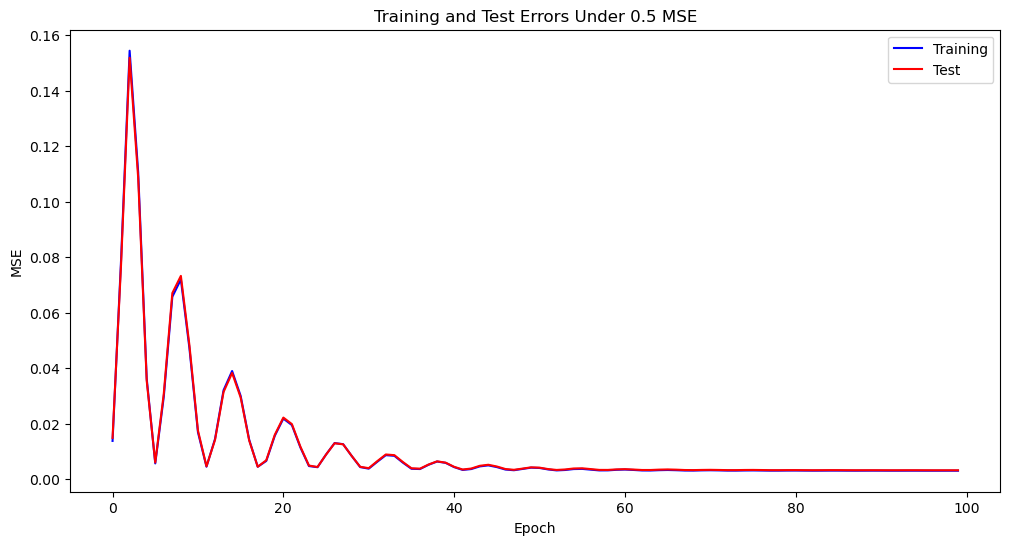

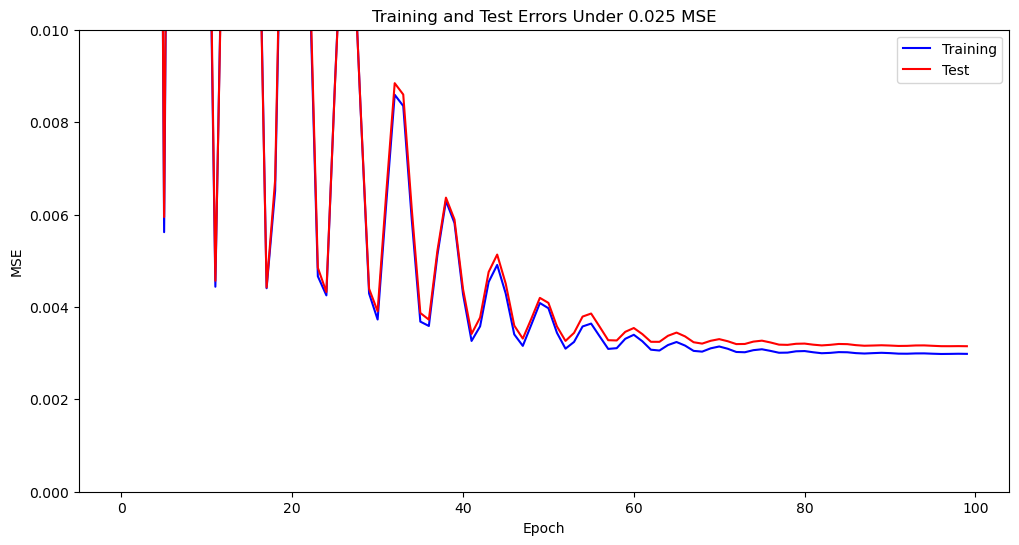

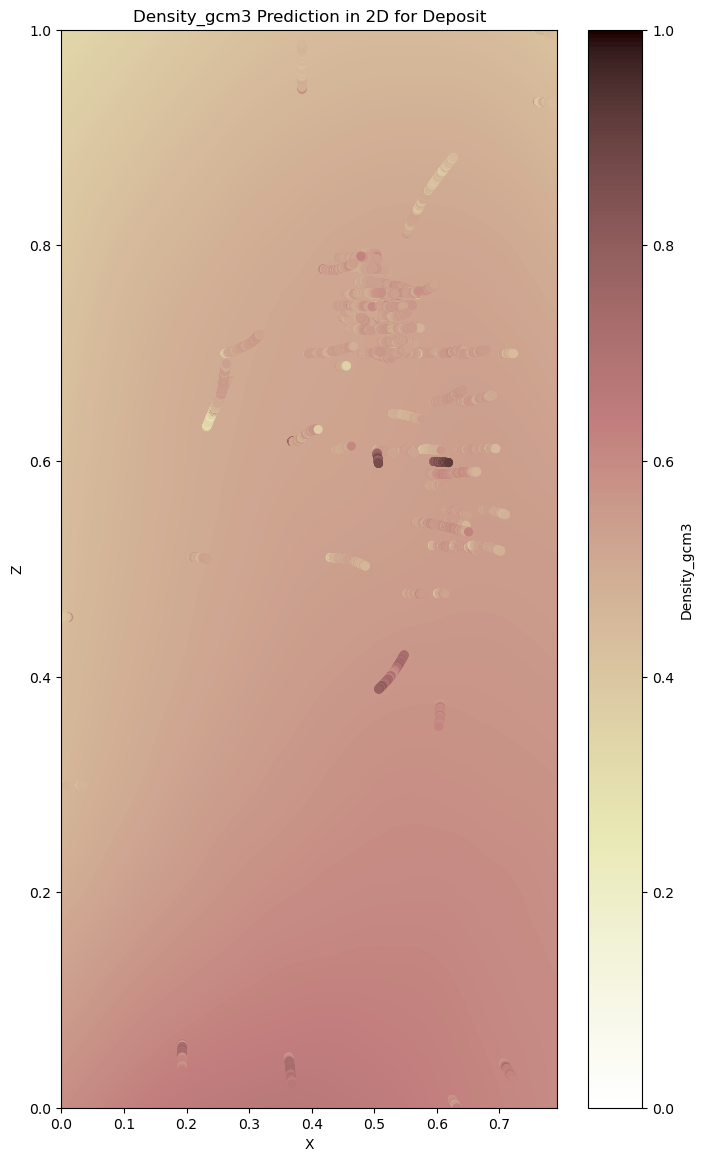

In [17]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
deposit_data = two_composite_1mineral.dropna(subset=[mineral])
    
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
deposit_data.loc[:, [mineral]] = scaler.fit_transform(deposit_data.loc[:, [mineral]])

x = deposit_data[['X', 'Y']].values  # Use X, Y, and Z coordinates
y = deposit_data[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(deposit_data), 2)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
    nn.Linear(in_features=2, out_features=20000),
    nn.ReLU(),
    nn.Linear(in_features=20000, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(100):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 10 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.01)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()




# Define a grid of points for prediction
x_grid_hole = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_grid_hole = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

# Make predictions for the grid
predictions_hole = model(torch.tensor(xy_grid_hole, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)



# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions_hole.ravel(), y.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

# Create a ScalarMappable for both plots using the same criteria
sm = ScalarMappable(cmap='pink_r')
sm.set_array([])  # Set an empty array to enforce the same vmin and vmax
sm.set_clim(vmin, vmax)  # Set the same vmin and vmax

plt.figure(figsize=(8, 14))

contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=500)  # Adjust levels as needed
scatter = plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=30, label='Selected Hole Data')

# Optionally, you can scatter plot the data points for this specific hole

# Add a colorbar associated with both plots
ax = plt.gca()
cb = plt.colorbar(sm, label=mineral, ax=ax)
# Set the color mapping based on the scatter plot

plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for Deposit')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract the X and Y coordinates
x_y_data = two_composite_1mineral[['X', 'Y']]

# Create a scatter plot of the X and Y coordinates
plt.figure(figsize=(14, 8))
plt.scatter(x_y_data['X'], x_y_data['Y'], s=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X and Y Coordinates')
plt.show()